# 4a5e1

I know the titles have something to do with the decimal digits of pi. Beyond that, I'm not sure.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# load the decimimal representation of pi
with open("pi.txt", "r") as f:
    pistr = f.read()
    pistr = pistr[0] + pistr[2:] # remove decimal point

titles = [
    "9-45-2-10-43-3-0-7-4-0-18-6-14-15-0-7-49-26-23-5-4-7-14-13-26-2-1-6-4-6-1-14-7-47-27-0-28-3-5-3-37-18-0-11-1-23-1-3-1-16-3-37-14-6-2-14",
    "4-4-6-4-10-2-6-15-6-3-24-8-11-1-3-19-13-9-11-25-4-30-8-54-29-37-4-2-14-14-19-0-32-12-40-4-2-13-13-1-21-2-26-23-6-12-0-34",
    "11-27-4-0-8-25-22-1-3-15-14-5-27-13-8-15-7-27-15-10-1-1-35-3-6-21-1-4-48-15-18-5-30-10-6-3-2-16-0-2-30-25-6-26-1-17-8-22-3-6-7-3-31-3-3-15-10-2-14-35-44-31-6-63-0-5",
    "7-3-3-4-4-1-9-2-2-9-12-7-40-11-0-26-14-8-14-20-1-29-13-21-17-4-29-21-28-6-15-25-9-8-19-11-10-42-8-18-50-12-20-23-28-12-11-11-9-1-19-0-25-13-10-5-8-34-0-4-26-7-0-41",
    "25-7-34-12-31-7-43-5-7-4-19-5-0-5-1-18-8-4-18-36-3-7-20-6-19-10-3-2-27-2-46-10-4-5-18-26-18-1-3-52-13-25-2-0-0-5-8-13-3-8-1-15-1-0-38-27-2-13-23-38",
    "22-43-11-39-3-25-13-9-28-11-6-32-24-2-16-4-3-30-18-0-6-58-38-2-46-10-8-0-3-10",
    "1-0-23-12-4-15-10-6-16-44-33-16-19-9-18-2-0-6-4-0-5-55-15-24-43-5-22-11-1-4",
    "23-0-2-1-8-33-5-7-3-5-20-10-24-35-3-1-18-22-2-2-23-2-3-39-33-18-24-10-4-3-13-55-23-3-14-5-35-7-29-1-3-13-41-2-3-52-62-8-3-0-21-22-2-0-5-4-9-27-1-8-3-5",
    "7-16-29-2-14-31-0-2-8-4-2-23-18-7-11-16-6-5-14-13-20-8-4-0-7-2-24-26-3-5-55-24-3-17-34-9-0-20-0-7-25-6-32-3-3-5-9-4-45-6-40-29-1-23-16-56-11-8",
    "3-25-6-3-19-2-14-17-12-21-12-1-28-6-16-21-0-0-51-9-9-32-2-9",
    "3-4-17-27-18-14-5-10-0-2-56-17-31-35-0-6-38-8-17-7-16-13",
    "9-22-0-0-26-39-9-2-24-31-14-31-29-5-7-16-8-29-0-50-11-5-6-7-49-8-40-1-1-27-27-29-6-0",
    "7-8-35-3-6-16-2-20-22-24-5-2-48-24-6-14-46-9-15-5-9-17-16-1",
    "9-27-2-3-4-0-0-14-12-24-7-42-5-17-10-17-29-7-7-22-14-29-4-1-40-40-47-16-31-36-10-45-21-18-37-2-31-1-14-15-29-7-13-5-59-6-6-5-6-7",
    "3-5-40-4-2-7-3-8-40-4-7-13-1-24-17-1-43-12-4-4-10-5-22-0-21-5-7-0-13-1-8-29",
    "10-0-2-17-32-2-8-30-24-0-1-7-16-0-19-1-36-0-0-2-0-34-6-7-2-4-2-1-8-20-42-20-41-47-5-49-25-25-16-6-3-0-9-9",
    ]


## Distribution of Numbers in Titles

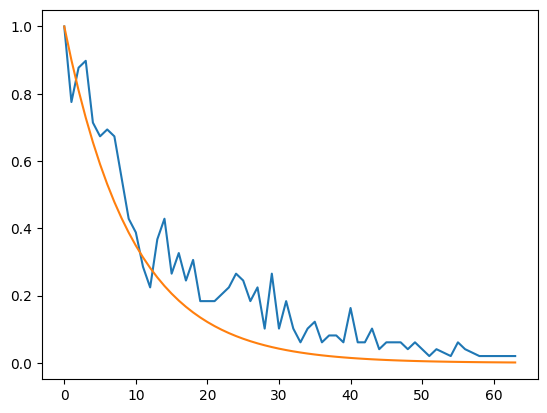

In [2]:
occurances = dict()
for title in titles:
    ds = [int(s) for s in title.split("-")]
    for d in ds:
        if d in occurances.keys():
            occurances[d] += 1
        else:
            occurances[d] = 1

x = np.array([x[0] for x in sorted(occurances.items())])
y = np.array([x[1] for x in sorted(occurances.items())])
z = np.cumsum(y)

f = 0.9 ** (x-1) * 0.9

plt.figure()
plt.plot(x, y/max(y))
plt.plot(x, f)
plt.show()

## Decoding Titles

My attempts at doing so. The code below hasn't produced anything meaningful yet.

1: 113419004509996886111232217952
3: 128179628982192111642068
3: 1635628669728660300591
3: 15580536203238558617568838665281
4: 559829454484148471064462636802998019885643289881
7: 6573265289721222140386626169632799372344365849999544598574427330
7: 6480177858317119343805228141803236933889897526263740147550
7: 630246004518188771682760
9: 30775224335880047616610168961054919909931776294133040986
9: 3555478854008200577715827127279511
9: 34969994012927098286578734944632617771517019526510
10: 55975208444522198880029452464029531100076628
11: 899906068052414187966991415264651664599263029458738006995225633113
22: 602365729857469704445030813320
23: 44388869648650591187995011042810528967712771201100489945031108
25: 307850008139988437622715120649355414563277444556187955019385


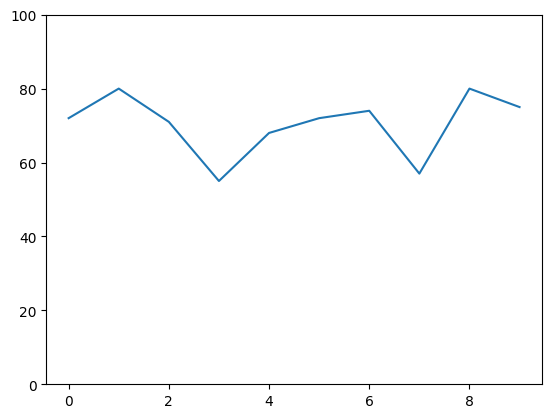

In [3]:
occurances = dict()
for i in range(10):
    occurances[i] = 0

for title in sorted(titles, key=lambda title: int(title.split("-")[0])):
    ds = [int(s) for s in title.split("-")]
    # print(ds[0], end=": ")
    i = 0
    print(ds[0], end=": ")
    for d in ds:
        i += d
        digit = int(pistr[i])
        print(digit, end="")
        occurances[digit] += 1
    print()

x = [x[0] for x in sorted(occurances.items())]
y = [x[1] for x in sorted(occurances.items())]

plt.figure()
plt.plot(x,y)
plt.ylim([0, 100])
plt.show()